# MNIST Fashion Dataset
### Predicting the type of clothing using various TensorFlow models


In [72]:
# Set up notebook headers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from metrics import *
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import History
from tensorflow.keras.datasets import fashion_mnist

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Data Collection
Fashion MNIST is a dataset within TensorFlow that contains 70,000 grayscale images of clothing items categorized into 10 classes, such as T-shirts, dresses, and shoes. Each image is 28x28 pixels, making it a popular benchmark for training and testing machine learning models for image classification tasks.

#### Loading Raw Data
Read in Fashion MNIST dataset directly via TensorFlow.

In [73]:
# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Display the shape of the datasets
print("Fashion MNIST Dataset Dimensions")
print("Shape of training images:", train_images.shape)
print("Shape of training labels:", train_labels.shape)
print("Shape of test images:", test_images.shape)
print("Shape of test labels:", test_labels.shape)

Fashion MNIST Dataset Dimensions
Shape of training images: (60000, 28, 28)
Shape of training labels: (60000,)
Shape of test images: (10000, 28, 28)
Shape of test labels: (10000,)


#### Visualise Raw Data
Have a peek at some images to see how they are presented.

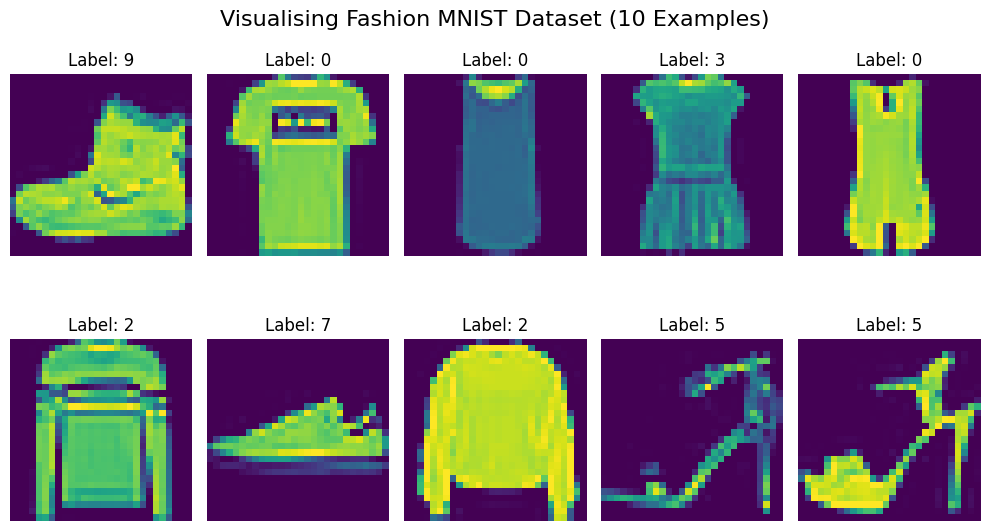

In [74]:
# Visualise the first 10 images in the training set
plt.figure(figsize = (10, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)  
    plt.imshow(train_images[i])
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')  
plt.tight_layout()
plt.suptitle("Visualising Fashion MNIST Dataset (10 Examples)", fontsize = 16)
plt.show()

The labels are provided as integers, so we will need to map them to the corresponding clothing categories for the final predictions.

In [75]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

#### Preprocess Data
Let's reshape the data and ensure pixel values in the images are normalised so the models can interpret them correctly. Whilst the labels don't necessarily need to be one-hot encoded, let's do so anyway for completeness. Finally, we'll need to split the entire dataset of 70,000 images into training, validation, and test sets using a 75/15/10 split, respectively.

In [76]:
# Combine the current train and test sets to create one dataset
images = np.concatenate([train_images, test_images], axis = 0)
labels = np.concatenate([train_labels, test_labels], axis = 0)

# Preprocess the data
num_classes = np.max(labels) + 1
images_mod = images.reshape((-1, images.shape[1], images.shape[1], 1)).astype('float32') / 255.0

In [77]:
# Split into training, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(images_mod, labels, test_size = 0.25)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.4)

In [78]:
# Print shape of datasets
print("Fashion MNIST Modified Dataset Dimensions")
print("Shape of training images:", x_train.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of validation images:", x_val.shape)
print("Shape of validation labels:", y_val.shape)
print("Shape of test images:", x_test.shape)
print("Shape of test labels:", y_test.shape)

Fashion MNIST Modified Dataset Dimensions
Shape of training images: (52500, 28, 28, 1)
Shape of training labels: (52500,)
Shape of validation images: (10500, 28, 28, 1)
Shape of validation labels: (10500,)
Shape of test images: (7000, 28, 28, 1)
Shape of test labels: (7000,)


#### Model Creation
We will be building various TensorFlow models and testing their performance on the test set to decide what the optimal configuration should be.

##### Model 1: Baseline

Build a simple neural network with 2 hidden layers and the Adam optimiser.

In [79]:
# Set up model by adding layers sequentially
base = models.Sequential()
base.add(layers.Flatten(input_shape = (x_train.shape[1], x_train.shape[1], 1)))
base.add(layers.Dense(units = 512, activation = 'relu'))
base.add(layers.Dense(units = 256, activation = 'relu'))
base.add(layers.Dense(units = 10, activation = 'softmax'))
base.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

# Define a History callback to record training metrics
history = History()

# Fit model on training data
base.fit(x_train, y_train, batch_size = 32, epochs = 10, callbacks = [history],  validation_data = (x_val, y_val))

# Print model summary
base.summary()

c:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.7844 - loss: 0.5999 - val_accuracy: 0.8542 - val_loss: 0.3962
Epoch 2/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8640 - loss: 0.3729 - val_accuracy: 0.8672 - val_loss: 0.3634
Epoch 3/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8773 - loss: 0.3272 - val_accuracy: 0.8747 - val_loss: 0.3469
Epoch 4/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8876 - loss: 0.3015 - val_accuracy: 0.8742 - val_loss: 0.3792
Epoch 5/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8922 - loss: 0.2814 - val_accuracy: 0.8780 - val_loss: 0.3350
Epoch 6/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8981 - loss: 0.2694 - val_accuracy: 0.8825 - val_loss: 0.3400
Epoch 7/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.9044 - loss: 0.2505 - val_accuracy: 0.8862 - val_loss: 0.3280
Epoch 8/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9081 -

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,456 (6.13 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,071,638 (4.09 MB)

Let's look at the training progress over all epochs.

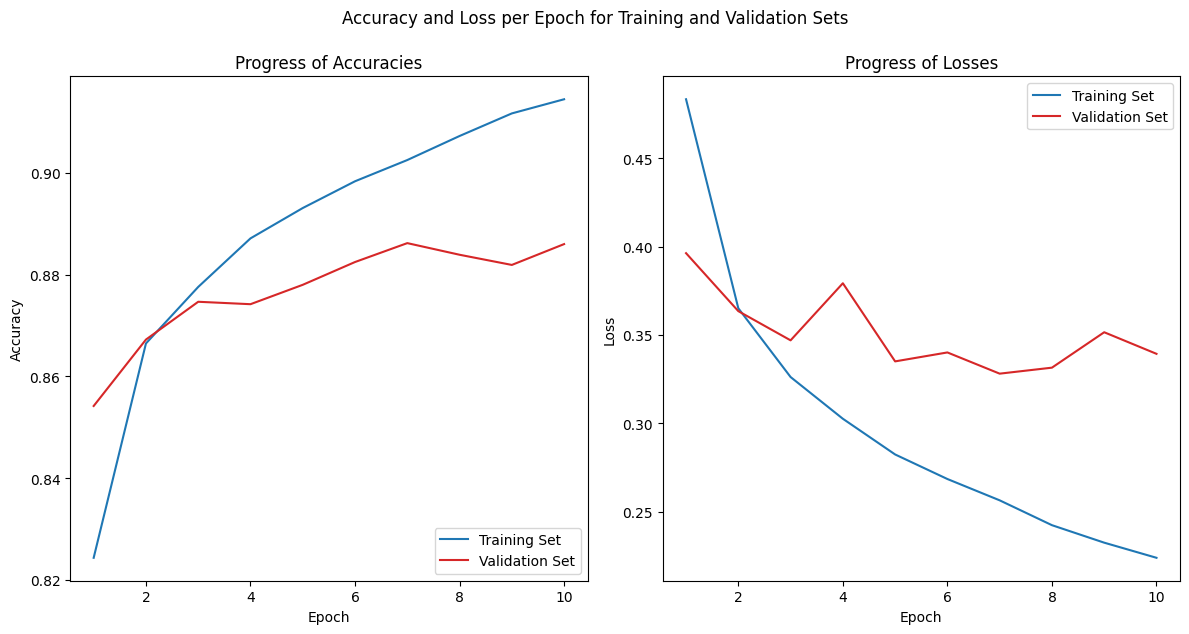

In [80]:
# Plot training progress for training and validation data
epochs = np.arange(1, 11)
training_progress(epochs, history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])

View performance metrics after predicting on the test set.

In [81]:
# Predict on test set
base_preds = base.predict(x_test)

# Extract confidence scores for predicted labels
confidence_scores = np.max(base_preds, axis = 1)

# Extract predicted labels
y_pred = np.argmax(base_preds, axis = 1)

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


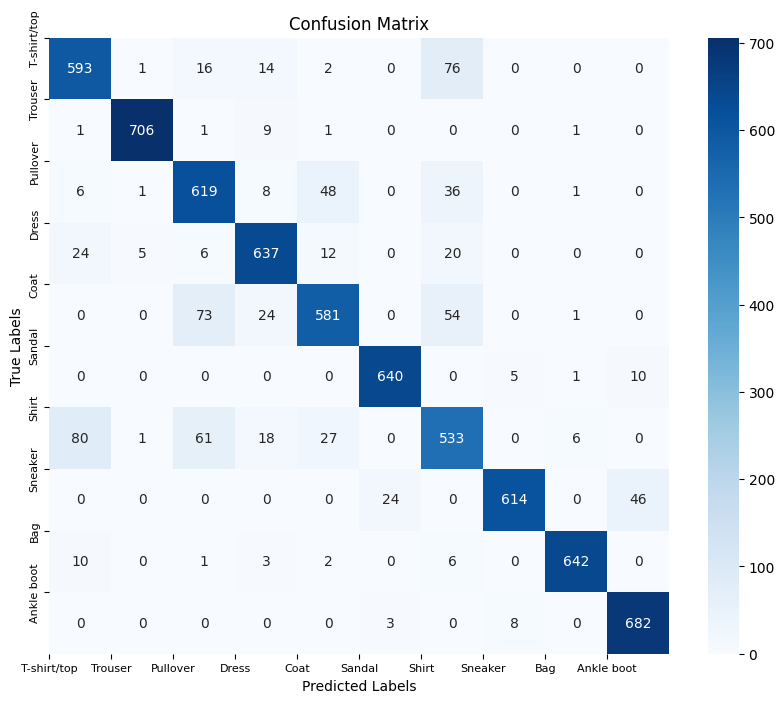

In [82]:
# Plot confusion matrix
confusion_matrix_ad(y_test, y_pred, num_classes, classes)

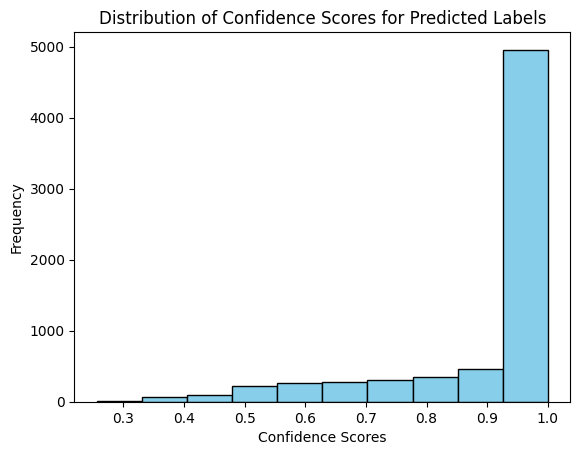

In [83]:
# Plot distribution of confidence scores
confidence_distribution(confidence_scores)

In [84]:
# Display classification report
classification_report_ad(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.8305    0.8447    0.8376       702
           1     0.9888    0.9819    0.9853       719
           2     0.7967    0.8609    0.8275       719
           3     0.8934    0.9048    0.8991       704
           4     0.8633    0.7926    0.8265       733
           5     0.9595    0.9756    0.9675       656
           6     0.7352    0.7342    0.7347       726
           7     0.9793    0.8977    0.9367       684
           8     0.9847    0.9669    0.9757       664
           9     0.9241    0.9841    0.9532       693

    accuracy                         0.8924      7000
   macro avg     0.8955    0.8943    0.8944      7000
weighted avg     0.8937    0.8924    0.8925      7000



**Comments**: 

##### Model 2: Convolutional Neural Network (CNN)

In [85]:
# Set up model by adding layers sequentially
cnn = models.Sequential()
cnn.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (x_train.shape[1], x_train.shape[1], 1)))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Dropout(0.1))

cnn.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
cnn.add(layers.Flatten())
cnn.add(layers.Dropout(0.1))
cnn.add(layers.Dense(64, activation = 'relu'))
cnn.add(layers.Dense(num_classes, activation = 'softmax'))
cnn.compile(optimizer = 'sgd',
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

# Define a History callback to record training metrics
history = History()

# Fit model on training data
cnn.fit(x_train, y_train, batch_size = 32, epochs = 10, callbacks = [history],  validation_data = (x_val, y_val))

# Print model summary
cnn.summary()

c:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.4061 - loss: 1.6181 - val_accuracy: 0.7425 - val_loss: 0.6991
Epoch 2/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.7390 - loss: 0.6848 - val_accuracy: 0.7807 - val_loss: 0.5891
Epoch 3/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7846 - loss: 0.5740 - val_accuracy: 0.8067 - val_loss: 0.5201
Epoch 4/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 139s 85ms/step - accuracy: 0.8086 - loss: 0.5174 - val_accuracy: 0.8327 - val_loss: 0.4600
Epoch 5/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.8248 - loss: 0.4727 - val_accuracy: 0.8471 - val_loss: 0.4291
Epoch 6/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.8427 - loss: 0.4312 - val_accuracy: 0.8455 - val_loss: 0.4158
Epoch 7/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.8466 - loss: 0.4154 - val_accuracy: 0.8589 - val_loss: 0.3851
Epoch 8/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.8555 

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,324 (364.55 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Let's look at the training progress over all epochs.

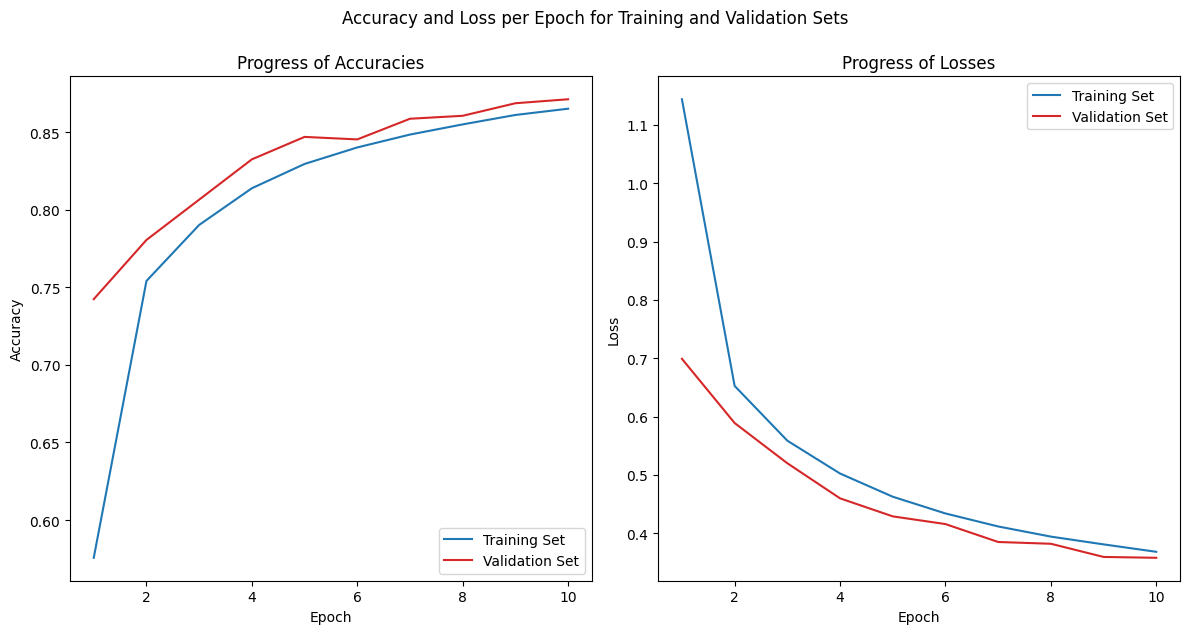

In [86]:
# Plot training progress for training and validation data
training_progress(epochs, history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])

View performance metrics after predicting on test set.

In [87]:
# Predict on test set
cnn_preds = cnn.predict(x_test)

# Extract confidence scores for predicted labels
confidence_scores = np.max(base_preds, axis = 1)

# Extract predicted labels
y_pred = np.argmax(base_preds, axis = 1)

219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


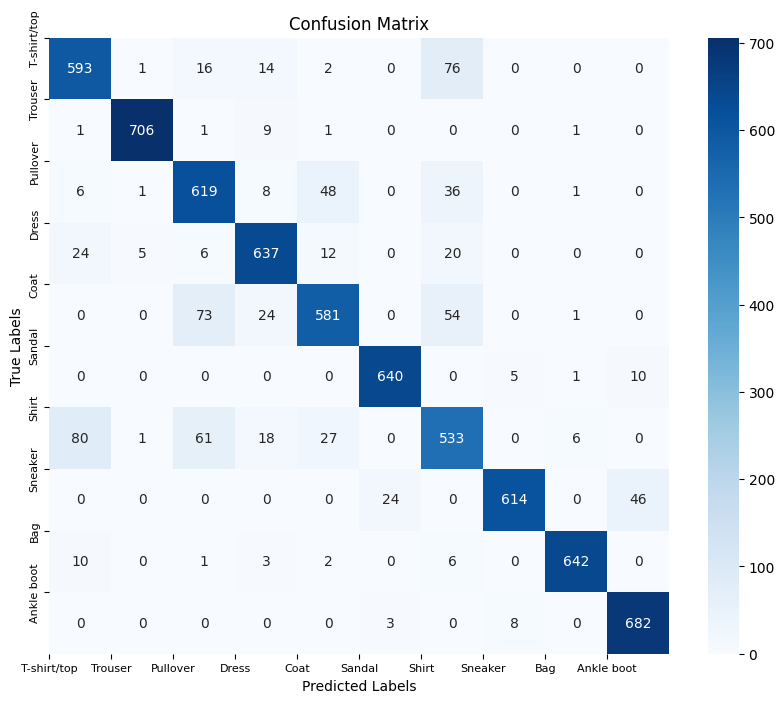

In [88]:
# Plot confusion matrix
confusion_matrix_ad(y_test, y_pred, num_classes, classes)

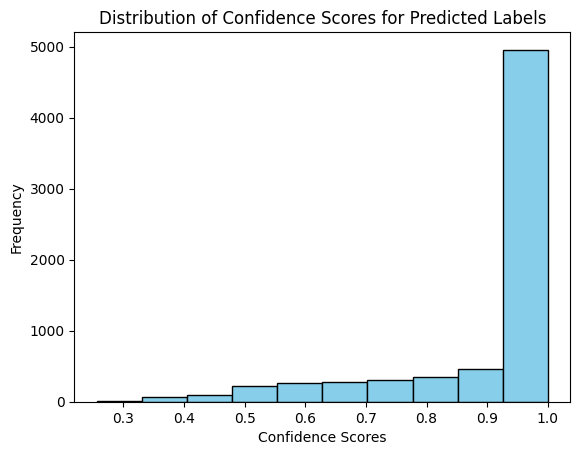

In [89]:
# Plot distribution of confidence scores
confidence_distribution(confidence_scores)

In [90]:
# Display classification report
classification_report_ad(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.8305    0.8447    0.8376       702
           1     0.9888    0.9819    0.9853       719
           2     0.7967    0.8609    0.8275       719
           3     0.8934    0.9048    0.8991       704
           4     0.8633    0.7926    0.8265       733
           5     0.9595    0.9756    0.9675       656
           6     0.7352    0.7342    0.7347       726
           7     0.9793    0.8977    0.9367       684
           8     0.9847    0.9669    0.9757       664
           9     0.9241    0.9841    0.9532       693

    accuracy                         0.8924      7000
   macro avg     0.8955    0.8943    0.8944      7000
weighted avg     0.8937    0.8924    0.8925      7000



**Comments**: 

##### Model 3: Deep Neural Network (DNN)

In [91]:
# Set up model by adding layers sequentially
dnn = models.Sequential()
dnn.add(layers.Flatten(input_shape = (x_train.shape[1], x_train.shape[1], 1)))

# Hidden layers with L2 regularization
dnn.add(layers.Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
dnn.add(layers.Dense(256, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
dnn.add(layers.Dense(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))

# Output layer
dnn.add(layers.Dense(num_classes, activation = 'softmax'))

# Compile the model
dnn.compile(optimizer = 'rmsprop',
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

# Define a History callback to record training metrics
history = History()

# Fit model on training data
dnn.fit(x_train, y_train, batch_size = 32, epochs = 10, callbacks = [history],  validation_data = (x_val, y_val))

# Print model summary
dnn.summary()

c:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.6936 - loss: 2.4155 - val_accuracy: 0.7610 - val_loss: 0.8610
Epoch 2/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.7905 - loss: 0.7807 - val_accuracy: 0.7751 - val_loss: 0.7869
Epoch 3/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8098 - loss: 0.7082 - val_accuracy: 0.7801 - val_loss: 0.7425
Epoch 4/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 589s 359ms/step - accuracy: 0.8128 - loss: 0.6764 - val_accuracy: 0.8230 - val_loss: 0.6631
Epoch 5/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8177 - loss: 0.6533 - val_accuracy: 0.8110 - val_loss: 0.6675
Epoch 6/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8235 - loss: 0.6410 - val_accuracy: 0.8013 - val_loss: 0.6801
Epoch 7/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8249 - loss: 0.6283 - val_accuracy: 0.8359 - val_loss: 0.6083
Epoch 8/10
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8288 - l

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,134,870 (4.33 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 567,436 (2.16 MB)

Let's look at the training progress over all epochs.

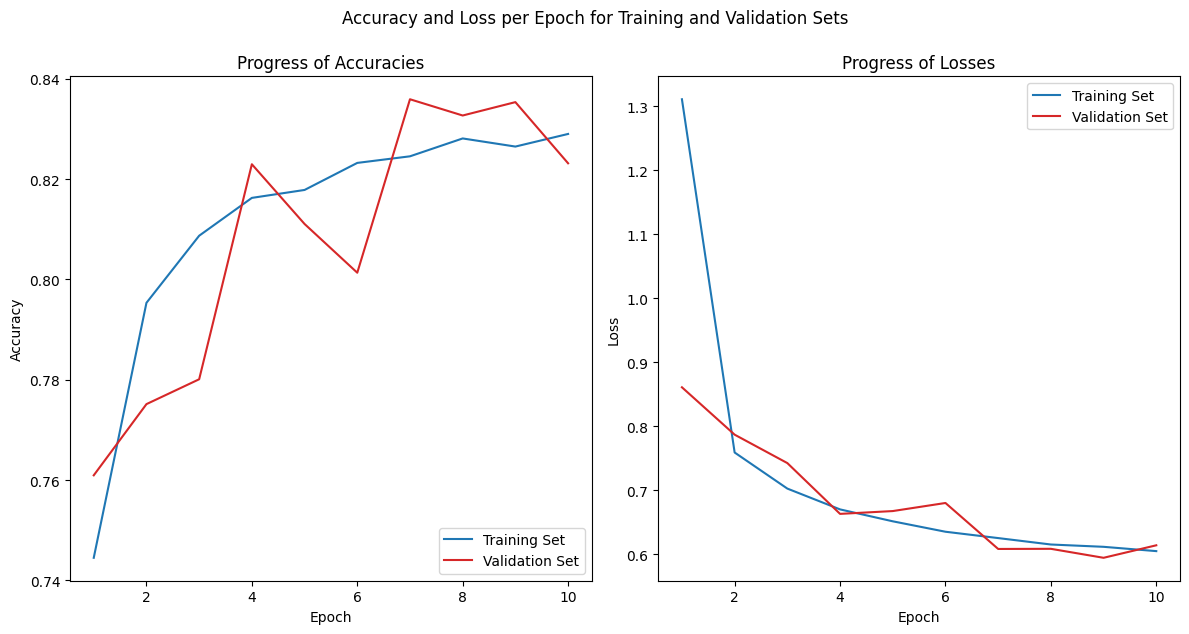

In [92]:
# Plot training progress for training and validation data
training_progress(epochs, history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])

View performance metrics after predicting on the test set.

In [93]:
# Predict on test set
dnn_preds = dnn.predict(x_test)

# Extract confidence scores for predicted labels
confidence_scores = np.max(base_preds, axis = 1)

# Extract predicted labels
y_pred = np.argmax(base_preds, axis = 1)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


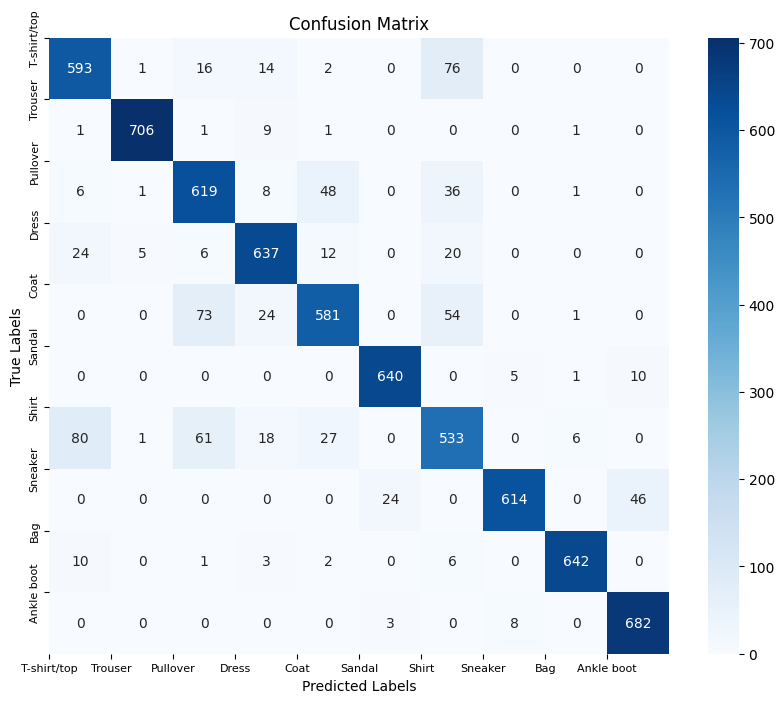

In [94]:
# Plot confusion matrix
confusion_matrix_ad(y_test, y_pred, num_classes, classes)

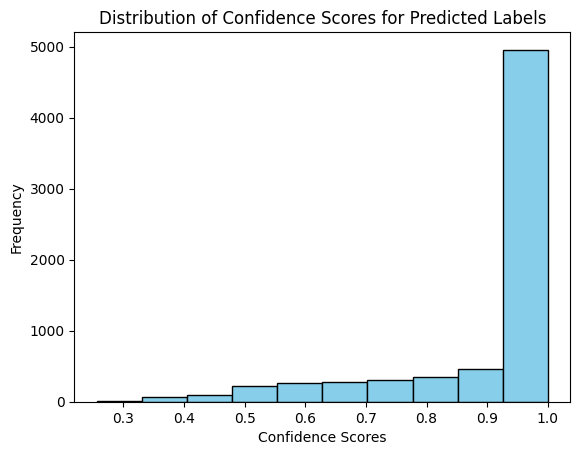

In [95]:
# Plot distribution of confidence scores
confidence_distribution(confidence_scores)

In [96]:
# Display classification report
classification_report_ad(y_test, y_pred)

              precision    recall  f1-score   support

           0     0.8305    0.8447    0.8376       702
           1     0.9888    0.9819    0.9853       719
           2     0.7967    0.8609    0.8275       719
           3     0.8934    0.9048    0.8991       704
           4     0.8633    0.7926    0.8265       733
           5     0.9595    0.9756    0.9675       656
           6     0.7352    0.7342    0.7347       726
           7     0.9793    0.8977    0.9367       684
           8     0.9847    0.9669    0.9757       664
           9     0.9241    0.9841    0.9532       693

    accuracy                         0.8924      7000
   macro avg     0.8955    0.8943    0.8944      7000
weighted avg     0.8937    0.8924    0.8925      7000



**Comments**: 

##### Model 4: ResNet

In [86]:
# Define Residual Block
def residual_block(x, filters, kernel_size):
    y = layers.Conv2D(filters, kernel_size, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    
    y = layers.Conv2D(filters, kernel_size, padding='same')(y)
    y = layers.BatchNormalization()(y)
    
    # Skip connection
    if x.shape[-1] != filters:
        x = layers.Conv2D(filters, kernel_size=(1, 1), padding='same')(x)
    y = layers.add([x, y])
    y = layers.Activation('relu')(y)
    return y

# Define ResNet model
def ResNet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolutional layer
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Residual blocks
    x = residual_block(x, filters=64, kernel_size=(3, 3))
    x = residual_block(x, filters=64, kernel_size=(3, 3))
    
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Create ResNet model
input_shape = train_images.shape[1:]
num_classes = len(set(train_labels))
resnet_model = ResNet(input_shape, num_classes)

# Compile the model
resnet_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
history = resnet_model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = resnet_model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 20ms/step - accuracy: 0.7688 - loss: 0.6591 - val_accuracy: 0.8398 - val_loss: 0.4393
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.8697 - loss: 0.3530 - val_accuracy: 0.8383 - val_loss: 0.4355
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.8881 - loss: 0.3049 - val_accuracy: 0.8228 - val_loss: 0.5325
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.8961 - loss: 0.2827 - val_accuracy: 0.8781 - val_loss: 0.3416
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.9065 - loss: 0.2521 - val_accuracy: 0.8597 - val_loss: 0.3859
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - accuracy: 0.9140 - loss: 0.2322 - val_accuracy: 0.8809 - val_loss: 0.3399
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - accuracy: 0.9188 - loss: 0.2186 - val_accuracy: 0.8949 - val_loss: 0.2867
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 50s 27ms/step - accuracy: 0.9225 -

Let's look at the training progress over all epochs.    

In [ ]:
# Plot training progress for training and validation data
training_progress(epochs, history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])

View performance metrics after predicting on the test set.

In [ ]:
# Predict on test set
resnet_preds = resnet.predict(x_test)

# Extract confidence scores for predicted labels
confidence_scores = np.max(base_preds, axis = 1)

# Extract predicted labels
y_pred = np.argmax(base_preds, axis = 1)

In [ ]:
# Plot confusion matrix
confusion_matrix_ad(y_test, y_pred, num_classes, classes)

In [ ]:
# Plot distribution of confidence scores
confidence_distribution(confidence_scores)

In [ ]:
# Display classification report
classification_report_ad(y_test, y_pred)

**Comments**: 

##### Model 5: Recurrent Neural Network (RNN)

In [100]:
# Set up model by adding layers sequentially
rnn = models.Sequential()
rnn.add(layers.Reshape((x_train[1], x_train[1]), input_shape = (x_train[1], x_train[1], 1)))

# LSTM layers with L2 regularization
rnn.add(layers.LSTM(256, return_sequences = True, kernel_regularizer = regularizers.l2(0.01)))
rnn.add(layers.LSTM(128, kernel_regularizer = regularizers.l2(0.01)))

# Output layer
rnn.add(layers.Dense(num_classes, activation = 'softmax'))

# Compile the model
rnn.compile(optimizer = 'adam',
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

# Define a History callback to record training metrics
history = History()

# Fit model on training data
rnn.fit(x_train, y_train, batch_size = 32, epochs = 10, callbacks = [history],  validation_data = (x_val, y_val))

# Print model summary
rnn.summary()

AttributeError: 'list' object has no attribute 'Reshape'

Let's look at the training progress over all epochs.    

In [ ]:
# Plot training progress for training and validation data
training_progress(epochs, history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])

View performance metrics after predicting on the test set.

In [ ]:
# Predict on test set
rnn_preds = rnn.predict(x_test)

# Extract confidence scores for predicted labels
confidence_scores = np.max(base_preds, axis = 1)

# Extract predicted labels
y_pred = np.argmax(base_preds, axis = 1)

In [ ]:
# Plot confusion matrix
confusion_matrix_ad(y_test, y_pred, num_classes, classes)

In [ ]:
# Plot distribution of confidence scores
confidence_distribution(confidence_scores)

In [ ]:
# Display classification report
classification_report_ad(y_test, y_pred)

**Comments**: 

#### Results
something about results

#### Ambiguous Images
Using the best model, find the 10 most ambiguous images in the test set based on predicted confidence scores.